## Code#1 Information

**Author:**  Shafagh Keyvanian [shkey@seas.upenn.edu]  
**Date**: *Spring 2024*

### For each Take
Converts Motive export .csv to Upper-arm Euler angles

Input: OptiTrack data: Motive exported .csv file
- Skeleton: Conventional Upper (27 Markers) - 43 Bones
- Gaps manually filled with "Linear Interpolation"
- Export: Bones- position & quaternion, Markers- position

Output: npz file with fields: time, bones, euler_angles
- Saves .npz file to folder: edited_exports\date
- File name: 1st-3rd word of take name, folder: Subject
- Bones fields: rows=frames, col=(quat(x y z w) pos[x y z])

In [3]:
#%% import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from tf.transformations import quaternion_matrix, euler_from_matrix, euler_matrix

In [8]:
#%% Read CSV file
csvfile = '../data/raw_exports/subject4_Rh_clinical.csv' 
raw_data = pd.read_csv(csvfile, header=[3, 5, 6], index_col=0)
# find text="Skeleton:" in the raw_data_cl header=4 and remove "Skeleton:" from the names
raw_data.rename(columns=lambda x: x.replace('Skeleton:', ''), level=0, inplace=True)
print(raw_data.head())
time = pd.read_csv(csvfile, header=6, usecols=[1]).values
# Make two chains for right and left upper limb 
chain_R = ['Skeleton', 'Ab', 'Chest','RShoulder','RUArm','RFArm','RHand']
chain_L = ['Skeleton', 'Ab', 'Chest','LShoulder','LUArm','LFArm','LHand']
chain_H = ['Skeleton', 'Ab', 'Chest','Neck', 'Head']

# make two data frames for right and left upper limb with the same structure as raw_data
skl_R = raw_data[chain_R].copy()
skl_L = raw_data[chain_L].copy()
skl_H = raw_data[chain_H].copy()

# # Add eul.x, eul.y, and eul.z columns
# for j in range(len(chain_R)):
#     skl_R[(chain_R[j], 'eul', 'x')] = np.nan
#     skl_R[(chain_R[j], 'eul', 'y')] = np.nan
#     skl_R[(chain_R[j], 'eul', 'z')] = np.nan
#     skl_L[(chain_L[j], 'eul', 'x')] = np.nan
#     skl_L[(chain_L[j], 'eul', 'y')] = np.nan
#     skl_L[(chain_L[j], 'eul', 'z')] = np.nan
# # print(skl_R.head())

                    Name  Skeleton                                             \
      Unnamed: 1_level_1  Rotation                                   Position   
Frame     Time (Seconds)         X         Y         Z         W            X   
0                   0.00  0.016325  0.025932  0.657310  0.752998 -1003.507507   
1                   0.01  0.018160  0.017010  0.690462  0.722941  -999.239563   
2                   0.02  0.013279 -0.000040  0.710054  0.704022 -1002.022766   
3                   0.03  0.000666 -0.021077  0.722243  0.691318 -1003.634216   
4                   0.04 -0.015606 -0.042826  0.727320  0.684783 -1002.280823   

                                     Ab            ...        RWRA  \
                               Rotation            ...    Position   
Frame           Y           Z         X         Y  ...         Z.1   
0     -148.735489  950.894409  0.046252  0.052208  ...  835.376892   
1     -148.126221  960.241638  0.067141  0.064896  ...  835.368164   
2

/tmp/ipykernel_21543/1006121079.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  strnm_dir_R = skl_R[('RShoulder', 'Position')] - skl_R[('Chest', 'Position')]
/tmp/ipykernel_21543/1006121079.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  strnm_dir_L = skl_L[('LShoulder', 'Position')] - skl_L[('Chest', 'Position')]
/tmp/ipykernel_21543/1006121079.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  strnm_dir_H = skl_H[('Neck', 'Position')] - skl_H[('Chest', 'Position')]
/tmp/ipykernel_21543/1006121079.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  pos = skl[(chain[j], 'Position')].iloc[t]
/tmp/ipykernel_21543/1006121079.py:23: PerformanceWarning: indexing past lexsort depth may impact performance.
  q = skl[(chain[j], 'Rotation')].iloc[t]


pos_R:     Raw                       FK                        Euler Angles             
Skeleton   [0. 0. 0.]                [0. 0. 0.]                [ 90.59 -10.11  -1.99]   
Ab         [-9.66 -2.02 54.25]       [-9.66 -2.02 54.25]       [ 0.77 21.99 -0.  ]      
Chest      [ 28.77  -6.7  236.64]    [ 28.77  -6.7  236.64]    [ 0.77 -6.61 -0.81]      
RShoulder  [ 49.43  16.22 399.34]    [ 42.6   16.68 400.  ]    [ 4.68 -8.72  8.72]      
RUArm      [ 34.68 146.04 386.77]    [ 27.85 146.5  387.43]    [ 67.38 -19.06  74.71]   
RFArm      [  7.41 229.49 116.47]    [  0.58 229.95 117.13]    [17.4  26.33  0.  ]      
RHand      [ -32.4   229.68 -125.19] [ -39.23  230.13 -124.53] [ 0.73 29.41 10.35]      
pos_L:     Raw                       FK                        Euler Angles             
Skeleton   [0. 0. 0.]                [0. 0. 0.]                [ 90.59 -10.11  -1.99]   
Ab         [-9.66 -2.02 54.25]       [-9.66 -2.02 54.25]       [ 0.77 21.99 -0.  ]      
Chest      [ 28.77  -

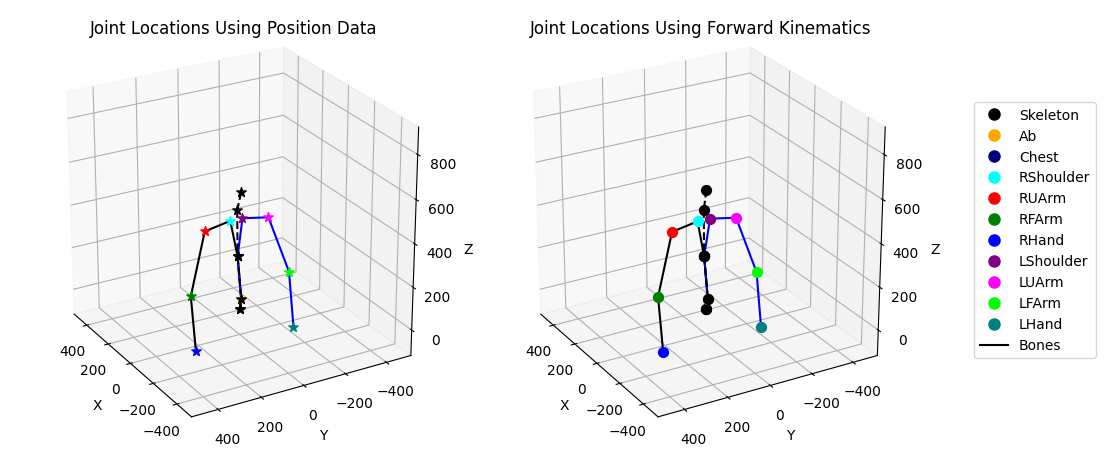

In [10]:
#%% Visualization of joint locations at time t
t = 1000
eul_seq = 'rzxy'

# Offset angle between strnm_dir_R/L and strnm_dir_H
strnm_dir_R = skl_R[('RShoulder', 'Position')] - skl_R[('Chest', 'Position')]
strnm_dir_L = skl_L[('LShoulder', 'Position')] - skl_L[('Chest', 'Position')]
strnm_dir_H = skl_H[('Neck', 'Position')] - skl_H[('Chest', 'Position')]
strnm_ang_R = np.arccos(np.dot(strnm_dir_R.iloc[t], strnm_dir_H.iloc[t])/(np.linalg.norm(strnm_dir_R.iloc[t])*np.linalg.norm(strnm_dir_H.iloc[t])))
strnm_ang_L = np.arccos(np.dot(strnm_dir_L.iloc[t], strnm_dir_H.iloc[t])/(np.linalg.norm(strnm_dir_L.iloc[t])*np.linalg.norm(strnm_dir_H.iloc[t])))

def get_positions(skl, chain):  
    positions = []
    for j in range(len(chain)):
        pos = skl[(chain[j], 'Position')].iloc[t]
        positions.append(np.array(pos))
    return positions - positions[0]

def get_euler(skl, chain):  
    eul = []
    R_prox = np.eye(3)
    for j in range(len(chain)):
        q = skl[(chain[j], 'Rotation')].iloc[t]
        R_global = quaternion_matrix(q)[:3,:3]
        R_rel = R_prox.T @ R_global
        R_prox = R_global
        eul_values = euler_from_matrix(R_rel, axes=eul_seq)
        # (ang1, ang2, ang3) = euler_from_matrix(R_rel, axes=eul_seq)
        # eul_values = np.array([ang1, ang2, ang3])
        eul.append(eul_values)
    return np.array(eul)

def forward_kinematics(skl, chain): 
    bone_pos = get_positions(skl, chain)
    bone_length = np.linalg.norm(np.diff(bone_pos, axis=0), axis=1)
    eul_angles = get_euler(skl, chain)
    
    fk_pose = np.zeros((len(eul_angles), 3))
    pos_prox = np.zeros(3)
    R_prox = np.eye(3)
    fk_pose[0] = bone_pos[0]
    for i in range(2):
        R_rel = euler_matrix(eul_angles[i, 0], eul_angles[i, 1], eul_angles[i, 2], axes=eul_seq)[:3, :3]
        R_prox = R_prox @ R_rel
        pos_prox += R_prox @ np.array([0, 0, bone_length[i]])
        fk_pose[i+1] = pos_prox

    for i in range(2, len(eul_angles)-1):
        R_rel = euler_matrix(eul_angles[i, 0], eul_angles[i, 1], eul_angles[i, 2], axes=eul_seq)[:3, :3]
        R_prox = R_prox @ R_rel
        if chain==chain_R:  
            if i==2:
                R_off = euler_matrix(0, 0, strnm_ang_R, axes=eul_seq)[:3, :3]
                pos_prox += R_prox @ R_off @ np.array([0, 0, bone_length[i]])
            else:
                pos_prox += R_prox @ np.array([bone_length[i], 0, 0])
        elif chain==chain_L:
            if i==2:
                R_off = euler_matrix(0, 0, -strnm_ang_L, axes=eul_seq)[:3, :3]
                pos_prox += R_prox @ R_off @ np.array([0, 0, bone_length[i]])
            else:
                pos_prox += R_prox @ np.array([-bone_length[i], 0, 0])
        elif chain==chain_H:
            pos_prox += R_prox @ np.array([0, 0, bone_length[i]])
        fk_pose[i+1] = pos_prox
    return fk_pose

# Get bone positions from raw data
pos_raw_R = get_positions(skl_R, chain_R)
pos_raw_L = get_positions(skl_L, chain_L)
pos_raw_H = get_positions(skl_H, chain_H)

# Get bone positions using forward kinematics
pos_fk_R = forward_kinematics(skl_R, chain_R)
pos_fk_L = forward_kinematics(skl_L, chain_L)
pos_fk_H = forward_kinematics(skl_H, chain_H)

eul_angles_R = get_euler(skl_R, chain_R)
eul_angles_L = get_euler(skl_L, chain_L)
eul_angles_H = get_euler(skl_H, chain_H)

print("{:<10} {:<25} {:<25} {:<25}".format("pos_R:", "Raw", "FK", "Euler Angles"))
for j in range(len(chain_R)):
    print("{:<10} {:<25} {:<25} {:<25}".format(chain_R[j], str(np.around(pos_raw_R[j], 2)), str(np.around(pos_fk_R[j], 2)), str(np.around(eul_angles_R[j]*180/np.pi, 2))))
print("{:<10} {:<25} {:<25} {:<25}".format("pos_L:", "Raw", "FK", "Euler Angles"))
for j in range(len(chain_L)):
    print("{:<10} {:<25} {:<25} {:<25}".format(chain_L[j], str(np.around(pos_raw_L[j], 2)), str(np.around(pos_fk_L[j], 2)), str(np.around(eul_angles_L[j]*180/np.pi, 2))))        
for j in range(len(chain_H)):
    print("{:<10} {:<25} {:<25} {:<25}".format(chain_H[j], str(np.around(pos_raw_H[j], 2)), str(np.around(pos_fk_H[j], 2)), str(np.around(eul_angles_H[j]*180/np.pi, 2))))

# Plot positions using raw position data and forward kinematics
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(11, 4.5), constrained_layout=True, num='Joint Locations')
# fig.subplots_adjust(left=-0.5, wspace=0.08, right=1.2)
for ax in axes:
    ax.set(xlabel='X', ylabel='Y', zlabel='Z', xlim=(-500, 500), ylim=(-500, 500), zlim=(-100, 900))
    ax.view_init(elev=25, azim=150)
ax1, ax2 = axes[0], axes[1]
ax1.set_title('Joint Locations Using Position Data', pad=8)
ax2.set_title('Joint Locations Using Forward Kinematics', pad=8)
# colors = ['k', 'y', 'm', 'c', 'r', 'g', 'b']
colors_R = ['black', 'orange', 'navy', 'cyan', 'red', 'green', 'blue']
colors_L = ['black', 'orange', 'navy', 'purple', 'magenta', 'lime', 'teal']
for j in range(len(chain_R)):
    ax1.scatter(pos_raw_R[j][0], pos_raw_R[j][1], pos_raw_R[j][2], label=f"{chain_R[j]}, Raw", marker='*', s=50, color=colors_R[j])
    ax1.scatter(pos_raw_L[j][0], pos_raw_L[j][1], pos_raw_L[j][2], label=f"{chain_L[j]}, Raw", marker='*', s=50, color=colors_L[j])
    ax2.scatter(pos_fk_R[j][0], pos_fk_R[j][1], pos_fk_R[j][2], label=f"{chain_R[j]}, FK", marker='o', s=50, color=colors_R[j])
    ax2.scatter(pos_fk_L[j][0], pos_fk_L[j][1], pos_fk_L[j][2], label=f"{chain_L[j]}, FK", marker='o', s=50, color=colors_L[j])
    if j!=0:
        ax1.plot([pos_raw_R[j][0], pos_raw_R[j-1][0]], [pos_raw_R[j][1], pos_raw_R[j-1][1]], [pos_raw_R[j][2], pos_raw_R[j-1][2]], 'k')
        ax1.plot([pos_raw_L[j][0], pos_raw_L[j-1][0]], [pos_raw_L[j][1], pos_raw_L[j-1][1]], [pos_raw_L[j][2], pos_raw_L[j-1][2]], 'b')
        ax2.plot([pos_fk_R[j][0], pos_fk_R[j-1][0]], [pos_fk_R[j][1], pos_fk_R[j-1][1]], [pos_fk_R[j][2], pos_fk_R[j-1][2]], 'k')
        ax2.plot([pos_fk_L[j][0], pos_fk_L[j-1][0]], [pos_fk_L[j][1], pos_fk_L[j-1][1]], [pos_fk_L[j][2], pos_fk_L[j-1][2]], 'b')
for j in range(1, len(chain_H)):
    ax1.scatter(pos_raw_H[j][0], pos_raw_H[j][1], pos_raw_H[j][2], label=f"{chain_H[j]}, Raw", marker='*', s=50, color='black')
    ax2.scatter(pos_fk_H[j][0], pos_fk_H[j][1], pos_fk_H[j][2], label=f"{chain_H[j]}, FK", marker='o', s=50, color='black')
    if j!=0:
        ax1.plot([pos_raw_H[j][0], pos_raw_H[j-1][0]], [pos_raw_H[j][1], pos_raw_H[j-1][1]], [pos_raw_H[j][2], pos_raw_H[j-1][2]], 'k--')
        ax2.plot([pos_fk_H[j][0], pos_fk_H[j-1][0]], [pos_fk_H[j][1], pos_fk_H[j-1][1]], [pos_fk_H[j][2], pos_fk_H[j-1][2]], 'k--')
ax2.legend(handles=
    [Line2D([],[], color=colors_R[j], linestyle='', marker='o', markersize=8, label=f"{chain_R[j]}") for j in range(len(chain_R))] + 
    [Line2D([],[], color=colors_L[j], linestyle='', marker='o', markersize=8, label=f"{chain_L[j]}") for j in range(3, len(chain_L))] + 
    [Line2D([],[], color='black', linestyle='-', label='Bones')],  loc='right', bbox_to_anchor=(1.4, 0.5))
plt.show()


In [ ]:
# Solve right upper limb chain Euler angles

eul_seq = 'rzxy'
# rot = np.zeros((len(chain_R),3, 3))
def get_euler(skl, chain):  
    eul = []
    R_prox = np.eye(3)
    for j in range(len(chain)):
        q = skl[(chain[j], 'Rotation')].iloc[t]
        R_global = quaternion_matrix(q)[:3,:3]
        R_rel = R_prox.T @ R_global
        R_prox = R_global
        eul_values = euler_from_matrix(R_rel, axes=eul_seq)
        eul.append(eul_values)
    return np.array(eul)

# for j in range(len(chain_R)):
#     chain_data_R = skl_R[chain_R[j]]
    
#     # Preallocate arrays for euler angles
#     num_rows = len(chain_data_R)
#     eul_array_R = np.zeros((num_rows, 3))

#     for t in range(num_rows):
#         eul_values = get_euler(skl_R, chain_R)
#         eul_array_R[t] = eul_values

#     # Add euler angles to DataFrame
#     skl_R[(chain_R[j], 'eul', 'x')] = eul_array_R[:, 0] *180/np.pi
#     skl_R[(chain_R[j], 'eul', 'y')] = eul_array_R[:, 1] *180/np.pi
#     skl_R[(chain_R[j], 'eul', 'z')] = eul_array_R[:, 2] *180/np.pi
#     print(skl_R[chain_R[j]])


# # quaternion (x, y, z, w) to euler angles for right upper limb
# q_R = np.zeros((len(chain_R), 4))
# euler_R = np.zeros((len(chain_R), 3))
# for t in range(len(time)):
#     rot = np.eye(3)
#     for j in range(len(chain_R)):
#         q_R[j] = skl_R[chain_R[j]]['Rotation'].iloc[t]
#         # relative rotation matrix from quaternion
#         rot = quaternion_matrix(q_R[j])[:3, :3] @ rot.T
#         eul_values = euler_from_matrix(rot.T, axes='sxyz')
#         print(t, eul_values)
#         # add euler angles to the dataframe at index t
#         skl_R[chain_R[j]].loc[t, ('eul', 'x')] = eul_values[0]
#         skl_R[chain_R[j]].loc[t, ('eul', 'y')] = eul_values[1]
#         skl_R[chain_R[j]].loc[t, ('eul', 'z')] = eul_values[2]

#         print(skl_R[chain_R[j]]['eul'])

# euler angles for right upper limb
eul_right = np.zeros((len(time), len(chain_R), 3))
for t in range(len(time)):
    eul = []
    R_prox = np.eye(3)
    for j in range(len(chain_R)):
        q = skl_R[(chain_R[j], 'Rotation')].iloc[t]
        R_global = quaternion_matrix(q)[:3,:3]
        R_rel = R_prox.T @ R_global
        R_prox = R_global
        eul_values = euler_from_matrix(R_rel, axes=eul_seq)
        eul.append(eul_values)

        # add euler angles to the dataframe at index t
        skl_R[(chain_R[j], 'eul', 'x')].iloc[t] = eul_values[0]
        skl_R[(chain_R[j], 'eul', 'y')].iloc[t] = eul_values[1]
        skl_R[(chain_R[j], 'eul', 'z')].iloc[t] = eul_values[2]
        # skl_R[chain_R[j]].loc[t, ('eul', 'x')] = eul_values[0]
        # skl_R[chain_R[j]].loc[t, ('eul', 'y')] = eul_values[1]
        # skl_R[chain_R[j]].loc[t, ('eul', 'z')] = eul_values[2]
        # print(t, skl_R[(chain_R[j], 'eul')])

        # print(skl_R[chain_R[j]]['eul'])
    eul_right[t] = np.array(eul)

# print(skl_R.head())
# print("*********** skl_R ***********")
# print(skl_R)

In [ ]:
# Draw Euler angles for right chain
# fig, axes = plt.subplots(len(chain_R), 3, figsize=(7, 16), constrained_layout=True, num='right_chain_angles')
# fig.suptitle('Right Chain Euler Angles', fontsize=14)
# for j in range(len(chain_R)):
#     eul_to_draw = eul_right[:, j] * 180/np.pi
#     # round to 2 decimal points
#     eul_to_draw = np.around(eul_to_draw, 2)
#     axes[j,0].scatter(eul_to_draw[:,0], eul_to_draw[:,1], label=f"{chain_R[j]}, 0, 1", marker='o', s=20, color='black')
#     axes[j,1].scatter(eul_to_draw[:,1], eul_to_draw[:,2], label=f"{chain_R[j]}, 1, 2", marker='o', s=20, color='black')
#     axes[j,2].scatter(eul_to_draw[:,2], eul_to_draw[:,0], label=f"{chain_R[j]}, 0, 2", marker='o', s=20, color='black')
#     axes[j,0].set_ylabel=(f"{chain_R[j]}, ax 0 vs 1")
#     axes[j,1].set_ylabel=(f"{chain_R[j]}, ax 1 vs 2")
#     axes[j,2].set_ylabel=(f"{chain_R[j]}, ax 0 vs 2")

# Draw Euler angles for right upper limb
sh_rot = np.around(eul_right[:,4,0] * 180/np.pi)
sh_abd = np.around(eul_right[:,4,1] * 180/np.pi)
sh_ext = np.around(eul_right[:,4,2] * 180/np.pi)
el_fle = np.around(eul_right[:,5,0] * 180/np.pi)
el_sup = np.around(eul_right[:,5,1] * 180/np.pi)

fig2, axes2 = plt.subplots(2, 3, figsize=(10, 6), constrained_layout=True, num='right_arm_angles')
fig2.suptitle('Right Upper Limb Euler Angles', fontsize=14, y=0.96)
fig2.subplots_adjust(wspace=0.5, hspace=0.4)

axes2[0,0].scatter(sh_rot[:], sh_abd[:], marker='o', s=10, color='blue')
axes2[0,0].set(xlabel='Shoulder Rotation (deg)', ylabel='Shoulder Abduction (deg)')
axes2[0,1].scatter(sh_rot[:], sh_ext[:], marker='o', s=10, color='blue')
axes2[0,1].set(xlabel='Shoulder Rotation (deg)', ylabel='Shoulder Extension (deg)')
axes2[0,2].scatter(sh_abd[:], sh_ext[:], marker='o', s=10, color='blue')
axes2[0,2].set(xlabel='Shoulder Abduction (deg)', ylabel='Shoulder Extension (deg)')

axes2[1,0].scatter(el_fle[:], sh_rot[:], marker='o', s=10, color='blue')
axes2[1,0].set(xlabel='Elbow Flexion (deg)', ylabel='Shoulder Rotation (deg)')
axes2[1,1].scatter(el_fle[:], sh_abd[:], marker='o', s=10, color='blue')
axes2[1,1].set(xlabel='Elbow Flexion (deg)', ylabel='Shoulder Abduction (deg)')
axes2[1,2].scatter(el_fle[:], sh_ext[:], marker='o', s=10, color='blue')
axes2[1,2].set(xlabel='Elbow Flexion (deg)', ylabel='Shoulder Extension (deg)')

plt.show()

In [ ]:
# Solve left upper limb chain Euler angles
rot = np.zeros((len(chain_L),3, 3))

for j in range(len(chain_L)):
    chain_data_L = raw_data[chain_L[j]]
    
    # Preallocate arrays for euler angles
    num_rows = len(chain_data_L)
    eul_array_L = np.zeros((num_rows, 3))

    for t in range(num_rows):
        # Quaternion (x, y, z, w) to euler angles for right upper limb
        q = chain_data_L['Rotation'].iloc[t]
        if j==0:
            rot[j] = quaternion_matrix(q)[:3, :3]
        else:
            rot[j] = quaternion_matrix(q)[:3, :3] @ rot[j-1].T
        eul_values = euler_from_matrix(rot[j].T, axes='sxyz') 
        eul_array_L[t] = eul_values

    # Add euler angles to DataFrame
    chain_data_L[(chain_L[j], 'eul', 'x')] = eul_array_L[:, 0] *180/np.pi
    chain_data_L[(chain_L[j], 'eul', 'y')] = eul_array_L[:, 1] *180/np.pi
    chain_data_L[(chain_L[j], 'eul', 'z')] = eul_array_L[:, 2] *180/np.pi

    # skl_L[chain_L[j]] = chain_data_L

In [ ]:
#%% Visualization of joint locations at time t
from matplotlib.lines import Line2D

t = 300
eul_seq = 'rzxy'

def get_positions(skl, chain):  
    positions = []
    for j in range(len(chain)):
        pos = skl[(chain[j], 'Position')].iloc[t]
        positions.append(np.array(pos))
        # pos_x = skl[(chain[j], 'Position', 'X')].iloc[t]
        # pos_y = skl[(chain[j], 'Position', 'Y')].iloc[t]
        # pos_z = skl[(chain[j], 'Position', 'Z')].iloc[t]
        # positions.append(np.array([pos_x, pos_y, pos_z]))
    return positions - positions[0]

def get_euler(skl, chain):  
    eul = []
    # rot = np.zeros((len(chain),3, 3))
    R_prox = np.eye(3)
    for j in range(len(chain)):
        q = skl[(chain[j], 'Rotation')].iloc[t]
        # qx = skl[(chain[j], 'Rotation', 'X')].iloc[t]
        # qy = skl[(chain[j], 'Rotation', 'Y')].iloc[t]
        # qz = skl[(chain[j], 'Rotation', 'Z')].iloc[t]
        # qw = skl[(chain[j], 'Rotation', 'W')].iloc[t]
        # q = np.array([qx, qy, qz, qw])
        R_global = quaternion_matrix(q)[:3,:3]
        R_rel = R_prox.T @ R_global
        R_prox = R_global
        eul_values = euler_from_matrix(R_rel, axes=eul_seq)
        eul.append(eul_values)
        # if j==0:
        #     rot[j] = quaternion_matrix(q)[:3, :3]
        # else:
        #     rot[j] = rot[j-1].T @ quaternion_matrix(q)[:3, :3] 
        # eul_values = euler_from_matrix(rot[j], axes=eul_seq) 
        # eul.append(eul_values)
    return np.array(eul)

def forward_kinematics(skl, chain): 
    # eul_angles = skl_R.xs('eul', level=1, axis=1).iloc[t].values.reshape(-1, 3) * np.pi/180
    bone_pos = get_positions(skl, chain)
    bone_length = np.linalg.norm(np.diff(bone_pos, axis=0), axis=1)
    eul_angles = get_euler(skl, chain)
    # print("chain: ", chain, "\neul_angles: ", np.around(eul_angles*180/np.pi, 2))
    
    fk_pose = np.zeros((len(eul_angles), 3))
    current_position = np.zeros(3)
    current_rotation = np.eye(3) #euler_matrix(eul_angles[0, 0], eul_angles[0, 1], eul_angles[0, 2], axes=eul_seq)[:3, :3]
    fk_pose[0] = current_position
    for i in range(2):
        R = euler_matrix(eul_angles[i, 0], eul_angles[i, 1], eul_angles[i, 2], axes=eul_seq)[:3, :3]
        current_rotation = current_rotation @ R
        current_position += current_rotation @ np.array([0, 0, bone_length[i]])
        fk_pose[i+1] = current_position

    for i in range(2, len(eul_angles)-1):
        if chain==chain_R:  
        # for i in range(len(eul_angles)-1):
            if i==2:
                R = euler_matrix(eul_angles[i, 0], -eul_angles[i, 1], eul_angles[i, 2], axes=eul_seq)[:3, :3]
                current_rotation = current_rotation @ R
                current_position += current_rotation @ np.array([0, 0, bone_length[i]])
            else:
                R = euler_matrix(eul_angles[i, 0], -eul_angles[i, 1], eul_angles[i, 2], axes=eul_seq)[:3, :3]
                current_rotation = current_rotation @ R
                current_position += current_rotation @ np.array([0, bone_length[i], 0])
            fk_pose[i+1] = current_position
        # return fk_pose
        elif chain==chain_L:
        # for i in range(len(eul_angles)-1):
            R = euler_matrix(-eul_angles[i, 0], -eul_angles[i, 1], eul_angles[i, 2], axes=eul_seq)[:3, :3]
            current_rotation = current_rotation @ R
            if i==2:
                current_position += current_rotation @ np.array([0, 0, bone_length[i]])
            else:
                # current_position += current_rotation @ np.array([0, 0, bone_length[i]])
                current_position += current_rotation @ np.array([0, -bone_length[i], 0])
            fk_pose[i+1] = current_position
    return fk_pose

# Get bone positions from raw data
pos_raw_R = get_positions(skl_R, chain_R)
pos_raw_L = get_positions(skl_L, chain_L)

# Get bone positions using forward kinematics
pos_fk_R = forward_kinematics(skl_R, chain_R)
pos_fk_L = forward_kinematics(skl_L, chain_L)
print("pos_raw_L: \n", pos_raw_L[:4])
print("pos_fk_L: \n", pos_fk_L[:4])
print("pos_raw_R: \n", pos_raw_R[:4])
print("pos_fk_R: \n", pos_fk_R[:4])

# eul_angles = get_euler(skl_L, chain_L)
# print("chain: ", chain_L, "\neul_angles: ", np.around(eul_angles*180/np.pi, 2))

# Plot positions using raw position data and forward kinematics
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(11, 4.5), constrained_layout=True, num='Joint Locations')
# fig.subplots_adjust(left=-0.5, wspace=0.08, right=1.2)
for ax in axes:
    ax.set(xlabel='X', ylabel='Y', zlabel='Z', xlim=(-500, 500), ylim=(-500, 500), zlim=(-100, 900))
    ax.view_init(elev=25, azim=-40)
ax1, ax2 = axes[0], axes[1]
ax1.set_title('Joint Locations Using Position Data', pad=8)
ax2.set_title('Joint Locations Using Forward Kinematics', pad=8)
# colors = ['k', 'y', 'm', 'c', 'r', 'g', 'b']
colors_R = ['black', 'orange', 'navy', 'cyan', 'red', 'green', 'blue']
colors_L = ['black', 'orange', 'navy', 'purple', 'magenta', 'lime', 'teal']
for j in range(len(chain_R)):
    ax1.scatter(pos_raw_R[j][0], pos_raw_R[j][1], pos_raw_R[j][2], label=f"{chain_R[j]}, Raw", marker='*', s=50, color=colors_R[j])
    ax1.scatter(pos_raw_L[j][0], pos_raw_L[j][1], pos_raw_L[j][2], label=f"{chain_L[j]}, Raw", marker='*', s=50, color=colors_L[j])
    ax2.scatter(pos_fk_R[j][0], pos_fk_R[j][1], pos_fk_R[j][2], label=f"{chain_R[j]}, FK", marker='o', s=50, color=colors_R[j])
    ax2.scatter(pos_fk_L[j][0], pos_fk_L[j][1], pos_fk_L[j][2], label=f"{chain_L[j]}, FK", marker='o', s=50, color=colors_L[j])
    if j!=0:
        ax1.plot([pos_raw_R[j][0], pos_raw_R[j-1][0]], [pos_raw_R[j][1], pos_raw_R[j-1][1]], [pos_raw_R[j][2], pos_raw_R[j-1][2]], 'k')
        ax1.plot([pos_raw_L[j][0], pos_raw_L[j-1][0]], [pos_raw_L[j][1], pos_raw_L[j-1][1]], [pos_raw_L[j][2], pos_raw_L[j-1][2]], 'b')
        ax2.plot([pos_fk_R[j][0], pos_fk_R[j-1][0]], [pos_fk_R[j][1], pos_fk_R[j-1][1]], [pos_fk_R[j][2], pos_fk_R[j-1][2]], 'k')
        ax2.plot([pos_fk_L[j][0], pos_fk_L[j-1][0]], [pos_fk_L[j][1], pos_fk_L[j-1][1]], [pos_fk_L[j][2], pos_fk_L[j-1][2]], 'b')
ax2.legend(handles=
    [Line2D([],[], color=colors_R[j], linestyle='', marker='o', markersize=8, label=f"{chain_R[j]}") for j in range(len(chain_R))] + 
    [Line2D([],[], color=colors_L[j], linestyle='', marker='o', markersize=8, label=f"{chain_L[j]}") for j in range(3, len(chain_L))] + 
    [Line2D([],[], color='black', linestyle='-', label='Bones')],  loc='right', bbox_to_anchor=(1.4, 0.5))
plt.show()
